### test baseline with hhblits using machine learning

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
%matplotlib inline

import sys 
sys.path.append("../..") 
from src import HHblits2array

In [2]:
# 1 prepare datasets
train_df = pd.read_pickle('../../datasets/middlefile/train_stab_df.pkl')
test_df = pd.read_pickle('../../datasets/middlefile/test_stab_df.pkl')
reversed_test_df = pd.read_pickle('../../datasets/middlefile/test_stab_reversed_df.pkl')
#print(train_df.shape)
train_df.head()

,pdb_id,pdb_chain,uniprot_id,mutation,shifted_mutation,ddg,seq_before,seq_after
0,1PY6,A,space,E9A,E5A,-0.1,TGRPEWIWLALGTALMGLGTLYFLVKGMGVSDPDAKKFYAITTLVP...,TGRPAWIWLALGTALMGLGTLYFLVKGMGVSDPDAKKFYAITTLVP...
1,1PY6,A,space,L13A,L9A,-1.8,TGRPEWIWLALGTALMGLGTLYFLVKGMGVSDPDAKKFYAITTLVP...,TGRPEWIWAALGTALMGLGTLYFLVKGMGVSDPDAKKFYAITTLVP...
2,1PY6,A,space,A39P,A35P,-0.6,TGRPEWIWLALGTALMGLGTLYFLVKGMGVSDPDAKKFYAITTLVP...,TGRPEWIWLALGTALMGLGTLYFLVKGMGVSDPDPKKFYAITTLVP...
3,1PY6,A,space,F42A,F38A,-2.0,TGRPEWIWLALGTALMGLGTLYFLVKGMGVSDPDAKKFYAITTLVP...,TGRPEWIWLALGTALMGLGTLYFLVKGMGVSDPDAKKAYAITTLVP...
4,1PY6,A,space,Y43A,Y39A,-2.1,TGRPEWIWLALGTALMGLGTLYFLVKGMGVSDPDAKKFYAITTLVP...,TGRPEWIWLALGTALMGLGTLYFLVKGMGVSDPDAKKFAAITTLVP...


In [3]:
from sklearn.utils import shuffle
shuffled = shuffle(train_df)

maxlen = 512
hhm_feature = []
hhmtool = HHblits2array.HHblits2array()
hhm_path = '../../datasets/middlefile/fasta/stab_hhm/'
for i in range(shuffled.shape[0]):
    hhm_before = hhmtool.convert(hhm_path + shuffled['pdb_id'][i] + '_' + shuffled['pdb_chain'][i] + '.hhm', maxlen).flatten().tolist()
    hhm_after = hhmtool.convert(hhm_path + shuffled['pdb_id'][i] + '_' + shuffled['pdb_chain'][i] + '_' + shuffled['shifted_mutation'][i] + '.hhm', maxlen).flatten().tolist()
    hhm_feature.append(hhm_before + hhm_after)

X = np.array(hhm_feature)
Y = shuffled['ddg'].values
print(X.shape)
print(Y.shape)

(187, 30720)
(187,)


In [4]:
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import pearsonr
from sklearn.model_selection import cross_val_score, KFold
sns.set(color_codes=True)

cv_result = []
cv_label = []
cv = KFold(n_splits=5)
for train_index, valid_index in cv.split(X):
    train_x,test_x = X[train_index], X[valid_index]
    train_y,test_y = Y[train_index], Y[valid_index]
    clf = XGBRegressor(n_jobs=-1)
    clf.fit(train_x, train_y)
    result = clf.predict(test_x)
    cv_result.append(result)
    cv_label.append(test_y)

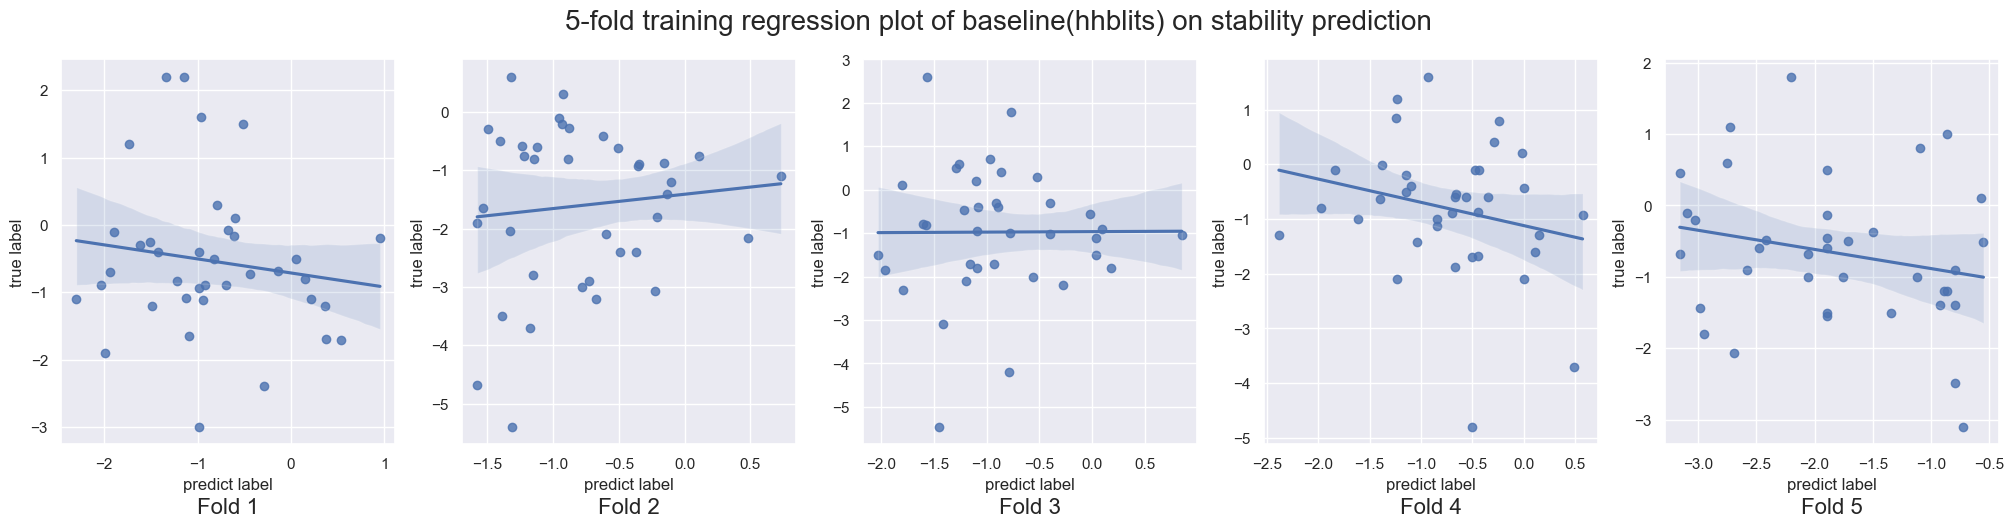

In [5]:
fig = plt.figure(figsize=(25,5))
rmse_list = []
r2_list = []
pcc_list = []
for i in range(5):
    rmse_list.append(np.sqrt(mean_squared_error(cv_label[i], cv_result[i])))
    r2_list.append(r2_score(cv_label[i], cv_result[i]))
    pcc_list.append(pearsonr(cv_label[i], cv_result[i])[0])
    plt.subplot(1, 5, i+1)
    plt.title('Fold ' + str(i+1), fontsize=16,y=-0.2)
    plt.ylabel("true label")
    plt.xlabel("predict label")
    sns.regplot(x=cv_result[i],y=cv_label[i],color='b')

plt.suptitle('5-fold training regression plot of baseline(hhblits) on stability prediction', fontsize=20)
plt.savefig('images/stab-hhblits/hhblits-xgb-5fold.png',dpi=300, bbox_inches = 'tight')
plt.show()

In [6]:
print('5-fold training avg rmse=', np.average(np.array(rmse_list)))
print('5-fold avg training r-square=', np.average(np.array(r2_list)))
print('5-fold avg training pearson-cc=',np.average(np.array(pcc_list)))

5-fold training avg rmse= 1.6169319470476253
5-fold avg training r-square= -0.8830187672589933
5-fold avg training pearson-cc= -0.09857581597436087


In [7]:
# try test set performance: prepare full training set
maxlen = 512
hhm_feature = []
hhmtool = HHblits2array.HHblits2array()
hhm_path = '../../datasets/middlefile/fasta/stab_hhm/'
for i in range(train_df.shape[0]):
    hhm_before = hhmtool.convert(hhm_path + train_df['pdb_id'][i] + '_' + train_df['pdb_chain'][i] + '.hhm', maxlen).flatten().tolist()
    hhm_after = hhmtool.convert(hhm_path + train_df['pdb_id'][i] + '_' + train_df['pdb_chain'][i] + '_' + train_df['shifted_mutation'][i] + '.hhm', maxlen).flatten().tolist()
    hhm_feature.append(hhm_before + hhm_after)

X_train = np.array(hhm_feature)
Y_train = train_df['ddg'].values
print(X_train.shape)
print(Y_train.shape)

clf = XGBRegressor(n_jobs=-1)
clf.fit(X_train, Y_train)

# save model
clf.save_model('model/stab_xgb_hhblits.json')
# load model
clf = XGBRegressor(n_jobs=-1)
clf.load_model('model/stab_xgb_hhblits.json')

(187, 30720)
(187,)


(36, 30720)
(36,)


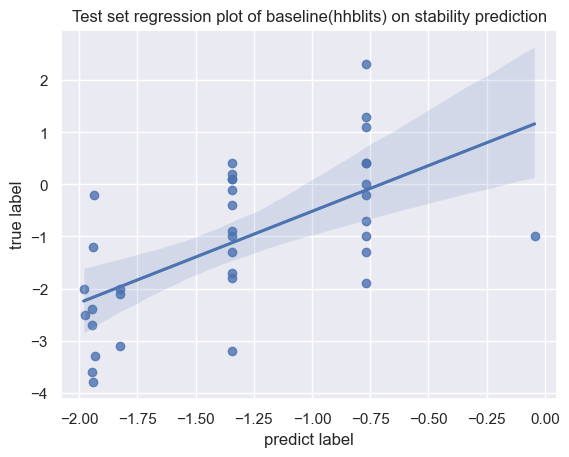

test training rmse= 1.2239172677208023
test training r-square= 0.2831048297914721
test training pearson-cc= 0.6167199774200333
pearson-cc p-value= 6.188529591693784e-05


In [8]:
# try test set performance
maxlen = 512
hhm_feature = []
hhmtool = HHblits2array.HHblits2array()
hhm_path = '../../datasets/middlefile/fasta/stab_hhm/'
for i in range(test_df.shape[0]):
    hhm_before = hhmtool.convert(hhm_path + test_df['pdb_id'][i] + '_' + test_df['pdb_chain'][i] + '.hhm', maxlen).flatten().tolist()
    hhm_after = hhmtool.convert(hhm_path + test_df['pdb_id'][i] + '_' + test_df['pdb_chain'][i] + '_' + test_df['shifted_mutation'][i] + '.hhm', maxlen).flatten().tolist()
    hhm_feature.append(hhm_before + hhm_after)

X_test = np.array(hhm_feature)
Y_test = test_df['ddg'].values
print(X_test.shape)
print(Y_test.shape)

Y_pred = clf.predict(X_test)

plt.title('Test set regression plot of baseline(hhblits) on stability prediction')
plt.ylabel("true label")
plt.xlabel("predict label")
sns.regplot(x=Y_pred,y=Y_test,color='b')
plt.savefig('images/stab-hhblits/hhblits-xgb-test.png',dpi=300, bbox_inches = 'tight')
plt.show()

print('test training rmse=', np.sqrt(mean_squared_error(Y_test, Y_pred)))
print('test training r-square=', r2_score(Y_test, Y_pred))
print('test training pearson-cc=',pearsonr(Y_test, Y_pred)[0])
print('pearson-cc p-value=',pearsonr(Y_test, Y_pred)[1])

In [9]:
# try test set performance: prepare full training set
maxlen = 512
hhm_feature = []
hhmtool = HHblits2array.HHblits2array()
hhm_path = '../../datasets/middlefile/fasta/stab_hhm/'
for i in range(train_df.shape[0]):
    hhm_before = hhmtool.convert(hhm_path + train_df['pdb_id'][i] + '_' + train_df['pdb_chain'][i] + '.hhm', maxlen).flatten().tolist()
    hhm_after = hhmtool.convert(hhm_path + train_df['pdb_id'][i] + '_' + train_df['pdb_chain'][i] + '_' + train_df['shifted_mutation'][i] + '.hhm', maxlen).flatten().tolist()
    hhm_feature.append(hhm_before + hhm_after)

X_train = np.array(hhm_feature)
Y_train = train_df['ddg'].values
print(X_train.shape)
print(Y_train.shape)

other_params = {'learning_rate': 0.01, 'n_estimators': 450, 'max_depth': 5, 'min_child_weight': 1, 'seed': 0,
                    'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 1}


#cv_params = {'n_estimators': [400, 500, 600, 700, 800]} # 500
#cv_params = {'n_estimators': [400, 450, 500, 550]} # 450
#cv_params = {'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.3]} # 0.01
#cv_params = {'max_depth': [5, 10, 20, 50]}
'''
clf = XGBRegressor(**other_params)
from sklearn.model_selection import GridSearchCV
optimized_GBM = GridSearchCV(estimator=clf, param_grid=cv_params, scoring='r2', cv=3, verbose=1, n_jobs=-1)
optimized_GBM.fit(X_train, Y_train)
print(optimized_GBM.best_params_)
'''

clf = XGBRegressor(**other_params)
clf.fit(X_train, Y_train)

# save model
clf.save_model('model/stab_xgb_hhblits_gs.json')
# load model
clf = XGBRegressor(n_jobs=-1)
clf.load_model('model/stab_xgb_hhblits_gs.json')

(187, 30720)
(187,)


(36, 30720)
(36,)


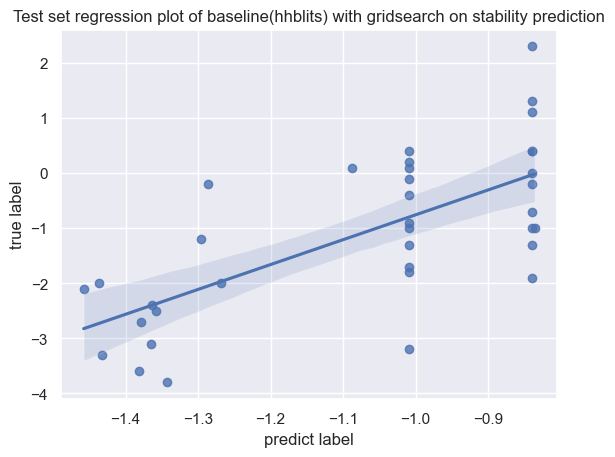

test training rmse= 1.3028507893830648
test training r-square= 0.18765429020457192
test training pearson-cc= 0.6903131256557788
pearson-cc p-value= 3.1818410364204718e-06


In [10]:
# try test set performance
maxlen = 512
hhm_feature = []
hhmtool = HHblits2array.HHblits2array()
hhm_path = '../../datasets/middlefile/fasta/stab_hhm/'
for i in range(test_df.shape[0]):
    hhm_before = hhmtool.convert(hhm_path + test_df['pdb_id'][i] + '_' + test_df['pdb_chain'][i] + '.hhm', maxlen).flatten().tolist()
    hhm_after = hhmtool.convert(hhm_path + test_df['pdb_id'][i] + '_' + test_df['pdb_chain'][i] + '_' + test_df['shifted_mutation'][i] + '.hhm', maxlen).flatten().tolist()
    hhm_feature.append(hhm_before + hhm_after)

X_test = np.array(hhm_feature)
Y_test = test_df['ddg'].values
print(X_test.shape)
print(Y_test.shape)

Y_pred = clf.predict(X_test)

plt.title('Test set regression plot of baseline(hhblits) with gridsearch on stability prediction')
plt.ylabel("true label")
plt.xlabel("predict label")
sns.regplot(x=Y_pred,y=Y_test,color='b')
plt.savefig('images/stab-hhblits/hhblits-xgb-test-gs.png',dpi=300, bbox_inches = 'tight')
plt.show()

print('test training rmse=', np.sqrt(mean_squared_error(Y_test, Y_pred)))
print('test training r-square=', r2_score(Y_test, Y_pred))
print('test training pearson-cc=',pearsonr(Y_test, Y_pred)[0])
print('pearson-cc p-value=',pearsonr(Y_test, Y_pred)[1])

(36, 30720)
(36,)
(26, 30720)
(26,)
(62, 30720)
(62,)


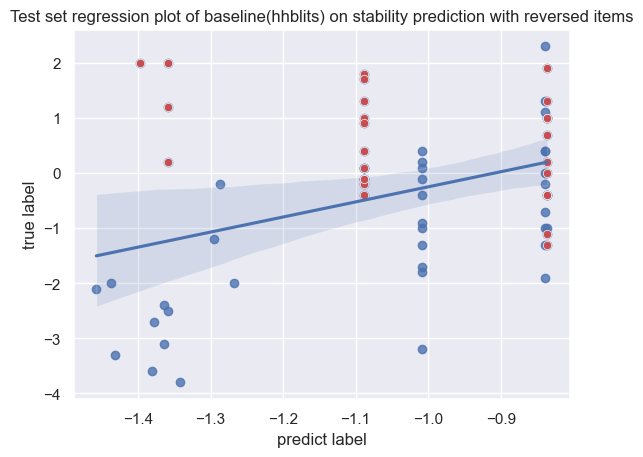

test training rmse= 1.5732700115731837
test training r-square= -0.10692387042188578
test training pearson-cc= 0.3821299614785213
pearson-cc p-value= 0.0021775297412482877


In [11]:
# try test set performance with reversed items

maxlen = 512
hhm_feature = []
hhmtool = HHblits2array.HHblits2array()
hhm_path = '../../datasets/middlefile/fasta/stab_hhm/'
for i in range(test_df.shape[0]):
    hhm_before = hhmtool.convert(hhm_path + test_df['pdb_id'][i] + '_' + test_df['pdb_chain'][i] + '.hhm', maxlen).flatten().tolist()
    hhm_after = hhmtool.convert(hhm_path + test_df['pdb_id'][i] + '_' + test_df['pdb_chain'][i] + '_' + test_df['shifted_mutation'][i] + '.hhm', maxlen).flatten().tolist()
    hhm_feature.append(hhm_before + hhm_after)

origin_X_test = np.array(hhm_feature)
origin_Y_test = test_df['ddg'].values
print(origin_X_test.shape)
print(origin_Y_test.shape)

maxlen = 512
hhm_feature = []
hhmtool = HHblits2array.HHblits2array()
hhm_path = '../../datasets/middlefile/fasta/stab_hhm/'
for i in range(reversed_test_df.shape[0]):
    hhm_before = hhmtool.convert(hhm_path + reversed_test_df['pdb_id'][i] + '_' + reversed_test_df['pdb_chain'][i] + '_' + reversed_test_df['shifted_mutation'][i] + '.hhm', maxlen).flatten().tolist()
    hhm_after = hhmtool.convert(hhm_path + reversed_test_df['pdb_id'][i] + '_' + reversed_test_df['pdb_chain'][i] + '.hhm', maxlen).flatten().tolist()
    hhm_feature.append(hhm_before + hhm_after)

reversed_X_test = np.array(hhm_feature)
reversed_Y_test = reversed_test_df['ddg'].values
print(reversed_X_test.shape)
print(reversed_Y_test.shape)

X_test = np.concatenate((origin_X_test,reversed_X_test),axis=0)
Y_test = np.concatenate((origin_Y_test,reversed_Y_test),axis=0)
print(X_test.shape)
print(Y_test.shape)

Y_pred = clf.predict(X_test)

plt.title('Test set regression plot of baseline(hhblits) on stability prediction with reversed items')
plt.ylabel("true label")
plt.xlabel("predict label")
sns.regplot(x=Y_pred,y=Y_test,color='b')
sns.scatterplot(x=Y_pred[origin_X_test.shape[0]:],y=Y_test[origin_Y_test.shape[0]:],color='r')
plt.savefig('images/stab-hhblits/hhblits-xgb-test-all.png',dpi=300, bbox_inches = 'tight')
plt.show()

print('test training rmse=', np.sqrt(mean_squared_error(Y_test, Y_pred)))
print('test training r-square=', r2_score(Y_test, Y_pred))
print('test training pearson-cc=',pearsonr(Y_test, Y_pred)[0])
print('pearson-cc p-value=',pearsonr(Y_test, Y_pred)[1])

In [12]:
# test lightGBM
import lightgbm as lgb
maxlen = 512
hhm_feature = []
hhmtool = HHblits2array.HHblits2array()
hhm_path = '../../datasets/middlefile/fasta/stab_hhm/'
for i in range(train_df.shape[0]):
    hhm_before = hhmtool.convert(hhm_path + train_df['pdb_id'][i] + '_' + train_df['pdb_chain'][i] + '.hhm', maxlen).flatten().tolist()
    hhm_after = hhmtool.convert(hhm_path + train_df['pdb_id'][i] + '_' + train_df['pdb_chain'][i] + '_' + train_df['shifted_mutation'][i] + '.hhm', maxlen).flatten().tolist()
    hhm_feature.append(hhm_before + hhm_after)

X_train = np.array(hhm_feature)
Y_train = train_df['ddg'].values
print(X_train.shape)
print(Y_train.shape)

clf = lgb.LGBMRegressor()
clf.fit(X_train, Y_train)

(187, 30720)
(187,)


LGBMRegressor()

(36, 30720)
(36,)
(26, 30720)
(26,)
(62, 30720)
(62,)


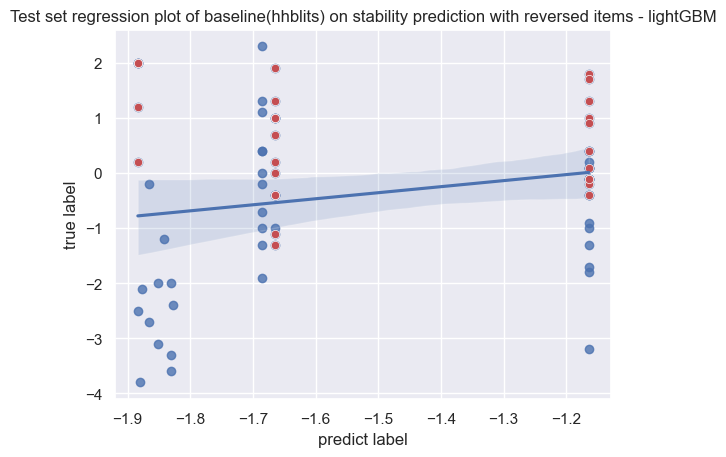

test training rmse= 1.8528680501531376
test training r-square= -0.5353246020431284
test training pearson-cc= 0.2149373557917867
pearson-cc p-value= 0.09341613323044205


In [13]:
# try test set performance with reversed items

maxlen = 512
hhm_feature = []
hhmtool = HHblits2array.HHblits2array()
hhm_path = '../../datasets/middlefile/fasta/stab_hhm/'
for i in range(test_df.shape[0]):
    hhm_before = hhmtool.convert(hhm_path + test_df['pdb_id'][i] + '_' + test_df['pdb_chain'][i] + '.hhm', maxlen).flatten().tolist()
    hhm_after = hhmtool.convert(hhm_path + test_df['pdb_id'][i] + '_' + test_df['pdb_chain'][i] + '_' + test_df['shifted_mutation'][i] + '.hhm', maxlen).flatten().tolist()
    hhm_feature.append(hhm_before + hhm_after)

origin_X_test = np.array(hhm_feature)
origin_Y_test = test_df['ddg'].values
print(origin_X_test.shape)
print(origin_Y_test.shape)

maxlen = 512
hhm_feature = []
hhmtool = HHblits2array.HHblits2array()
hhm_path = '../../datasets/middlefile/fasta/stab_hhm/'
for i in range(reversed_test_df.shape[0]):
    hhm_before = hhmtool.convert(hhm_path + reversed_test_df['pdb_id'][i] + '_' + reversed_test_df['pdb_chain'][i] + '_' + reversed_test_df['shifted_mutation'][i] + '.hhm', maxlen).flatten().tolist()
    hhm_after = hhmtool.convert(hhm_path + reversed_test_df['pdb_id'][i] + '_' + reversed_test_df['pdb_chain'][i] + '.hhm', maxlen).flatten().tolist()
    hhm_feature.append(hhm_before + hhm_after)

reversed_X_test = np.array(hhm_feature)
reversed_Y_test = reversed_test_df['ddg'].values
print(reversed_X_test.shape)
print(reversed_Y_test.shape)

X_test = np.concatenate((origin_X_test,reversed_X_test),axis=0)
Y_test = np.concatenate((origin_Y_test,reversed_Y_test),axis=0)
print(X_test.shape)
print(Y_test.shape)

Y_pred = clf.predict(X_test)

plt.title('Test set regression plot of baseline(hhblits) on stability prediction with reversed items - lightGBM')
plt.ylabel("true label")
plt.xlabel("predict label")
sns.regplot(x=Y_pred,y=Y_test,color='b')
sns.scatterplot(x=Y_pred[origin_X_test.shape[0]:],y=Y_test[origin_Y_test.shape[0]:],color='r')
plt.savefig('images/stab-hhblits/hhblits-lgb-test-all.png',dpi=300, bbox_inches = 'tight')
plt.show()

print('test training rmse=', np.sqrt(mean_squared_error(Y_test, Y_pred)))
print('test training r-square=', r2_score(Y_test, Y_pred))
print('test training pearson-cc=',pearsonr(Y_test, Y_pred)[0])
print('pearson-cc p-value=',pearsonr(Y_test, Y_pred)[1])

(187, 30720)
(187,)
(36, 30720)
(36,)
(26, 30720)
(26,)
(62, 30720)
(62,)


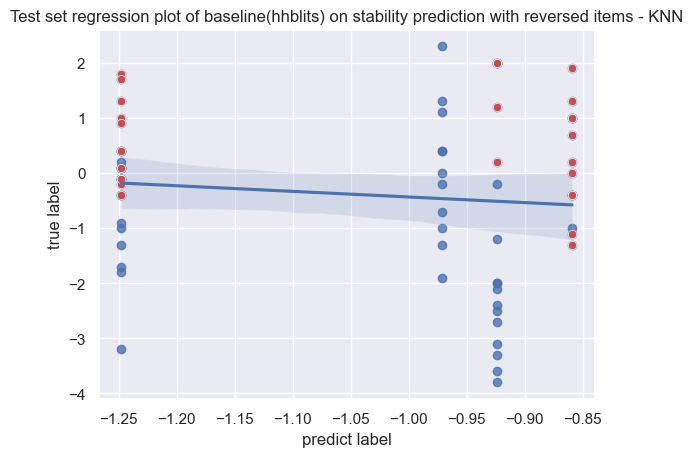

test training rmse= 1.6538061233253392
test training r-square= -0.2231519584620827
test training pearson-cc= -0.11139014441960941
pearson-cc p-value= 0.3887293268538543


In [14]:
# test KNN
from sklearn.neighbors import KNeighborsRegressor

maxlen = 512
hhm_feature = []
hhmtool = HHblits2array.HHblits2array()
hhm_path = '../../datasets/middlefile/fasta/stab_hhm/'
for i in range(train_df.shape[0]):
    hhm_before = hhmtool.convert(hhm_path + train_df['pdb_id'][i] + '_' + train_df['pdb_chain'][i] + '.hhm', maxlen).flatten().tolist()
    hhm_after = hhmtool.convert(hhm_path + train_df['pdb_id'][i] + '_' + train_df['pdb_chain'][i] + '_' + train_df['shifted_mutation'][i] + '.hhm', maxlen).flatten().tolist()
    hhm_feature.append(hhm_before + hhm_after)

X_train = np.array(hhm_feature)
Y_train = train_df['ddg'].values
print(X_train.shape)
print(Y_train.shape)

clf = KNeighborsRegressor()
clf.fit(X_train, Y_train)

# try test set performance with reversed items

maxlen = 512
hhm_feature = []
hhmtool = HHblits2array.HHblits2array()
hhm_path = '../../datasets/middlefile/fasta/stab_hhm/'
for i in range(test_df.shape[0]):
    hhm_before = hhmtool.convert(hhm_path + test_df['pdb_id'][i] + '_' + test_df['pdb_chain'][i] + '.hhm', maxlen).flatten().tolist()
    hhm_after = hhmtool.convert(hhm_path + test_df['pdb_id'][i] + '_' + test_df['pdb_chain'][i] + '_' + test_df['shifted_mutation'][i] + '.hhm', maxlen).flatten().tolist()
    hhm_feature.append(hhm_before + hhm_after)

origin_X_test = np.array(hhm_feature)
origin_Y_test = test_df['ddg'].values
print(origin_X_test.shape)
print(origin_Y_test.shape)

maxlen = 512
hhm_feature = []
hhmtool = HHblits2array.HHblits2array()
hhm_path = '../../datasets/middlefile/fasta/stab_hhm/'
for i in range(reversed_test_df.shape[0]):
    hhm_before = hhmtool.convert(hhm_path + reversed_test_df['pdb_id'][i] + '_' + reversed_test_df['pdb_chain'][i] + '_' + reversed_test_df['shifted_mutation'][i] + '.hhm', maxlen).flatten().tolist()
    hhm_after = hhmtool.convert(hhm_path + reversed_test_df['pdb_id'][i] + '_' + reversed_test_df['pdb_chain'][i] + '.hhm', maxlen).flatten().tolist()
    hhm_feature.append(hhm_before + hhm_after)

reversed_X_test = np.array(hhm_feature)
reversed_Y_test = reversed_test_df['ddg'].values
print(reversed_X_test.shape)
print(reversed_Y_test.shape)

X_test = np.concatenate((origin_X_test,reversed_X_test),axis=0)
Y_test = np.concatenate((origin_Y_test,reversed_Y_test),axis=0)
print(X_test.shape)
print(Y_test.shape)

Y_pred = clf.predict(X_test)

plt.title('Test set regression plot of baseline(hhblits) on stability prediction with reversed items - KNN')
plt.ylabel("true label")
plt.xlabel("predict label")
sns.regplot(x=Y_pred,y=Y_test,color='b')
sns.scatterplot(x=Y_pred[origin_X_test.shape[0]:],y=Y_test[origin_Y_test.shape[0]:],color='r')
plt.savefig('images/stab-hhblits/hhblits-knn-test-all.png',dpi=300, bbox_inches = 'tight')
plt.show()

print('test training rmse=', np.sqrt(mean_squared_error(Y_test, Y_pred)))
print('test training r-square=', r2_score(Y_test, Y_pred))
print('test training pearson-cc=',pearsonr(Y_test, Y_pred)[0])
print('pearson-cc p-value=',pearsonr(Y_test, Y_pred)[1])

(187, 30720)
(187,)
(36, 30720)
(36,)
(26, 30720)
(26,)
(62, 30720)
(62,)


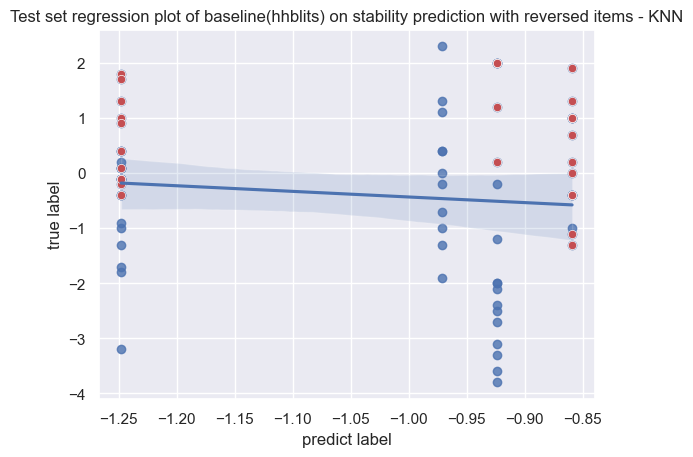

test training rmse= 1.6538061233253392
test training r-square= -0.2231519584620827
test training pearson-cc= -0.11139014441960941
pearson-cc p-value= 0.3887293268538543


In [15]:
# test KNN
from sklearn.neighbors import KNeighborsRegressor

maxlen = 512
hhm_feature = []
hhmtool = HHblits2array.HHblits2array()
hhm_path = '../../datasets/middlefile/fasta/stab_hhm/'
for i in range(train_df.shape[0]):
    hhm_before = hhmtool.convert(hhm_path + train_df['pdb_id'][i] + '_' + train_df['pdb_chain'][i] + '.hhm', maxlen).flatten().tolist()
    hhm_after = hhmtool.convert(hhm_path + train_df['pdb_id'][i] + '_' + train_df['pdb_chain'][i] + '_' + train_df['shifted_mutation'][i] + '.hhm', maxlen).flatten().tolist()
    hhm_feature.append(hhm_before + hhm_after)

X_train = np.array(hhm_feature)
Y_train = train_df['ddg'].values
print(X_train.shape)
print(Y_train.shape)

clf = KNeighborsRegressor(n_neighbors=5, p=2, metric='minkowski')
clf.fit(X_train, Y_train)

# try test set performance with reversed items

maxlen = 512
hhm_feature = []
hhmtool = HHblits2array.HHblits2array()
hhm_path = '../../datasets/middlefile/fasta/stab_hhm/'
for i in range(test_df.shape[0]):
    hhm_before = hhmtool.convert(hhm_path + test_df['pdb_id'][i] + '_' + test_df['pdb_chain'][i] + '.hhm', maxlen).flatten().tolist()
    hhm_after = hhmtool.convert(hhm_path + test_df['pdb_id'][i] + '_' + test_df['pdb_chain'][i] + '_' + test_df['shifted_mutation'][i] + '.hhm', maxlen).flatten().tolist()
    hhm_feature.append(hhm_before + hhm_after)

origin_X_test = np.array(hhm_feature)
origin_Y_test = test_df['ddg'].values
print(origin_X_test.shape)
print(origin_Y_test.shape)

maxlen = 512
hhm_feature = []
hhmtool = HHblits2array.HHblits2array()
hhm_path = '../../datasets/middlefile/fasta/stab_hhm/'
for i in range(reversed_test_df.shape[0]):
    hhm_before = hhmtool.convert(hhm_path + reversed_test_df['pdb_id'][i] + '_' + reversed_test_df['pdb_chain'][i] + '_' + reversed_test_df['shifted_mutation'][i] + '.hhm', maxlen).flatten().tolist()
    hhm_after = hhmtool.convert(hhm_path + reversed_test_df['pdb_id'][i] + '_' + reversed_test_df['pdb_chain'][i] + '.hhm', maxlen).flatten().tolist()
    hhm_feature.append(hhm_before + hhm_after)

reversed_X_test = np.array(hhm_feature)
reversed_Y_test = reversed_test_df['ddg'].values
print(reversed_X_test.shape)
print(reversed_Y_test.shape)

X_test = np.concatenate((origin_X_test,reversed_X_test),axis=0)
Y_test = np.concatenate((origin_Y_test,reversed_Y_test),axis=0)
print(X_test.shape)
print(Y_test.shape)

Y_pred = clf.predict(X_test)

plt.title('Test set regression plot of baseline(hhblits) on stability prediction with reversed items - KNN')
plt.ylabel("true label")
plt.xlabel("predict label")
sns.regplot(x=Y_pred,y=Y_test,color='b')
sns.scatterplot(x=Y_pred[origin_X_test.shape[0]:],y=Y_test[origin_Y_test.shape[0]:],color='r')
plt.savefig('images/stab-hhblits/hhblits-knn-test-all2.png',dpi=300, bbox_inches = 'tight')
plt.show()

print('test training rmse=', np.sqrt(mean_squared_error(Y_test, Y_pred)))
print('test training r-square=', r2_score(Y_test, Y_pred))
print('test training pearson-cc=',pearsonr(Y_test, Y_pred)[0])
print('pearson-cc p-value=',pearsonr(Y_test, Y_pred)[1])

(187, 30720)
(187,)
(36, 30720)
(36,)
(26, 30720)
(26,)
(62, 30720)
(62,)


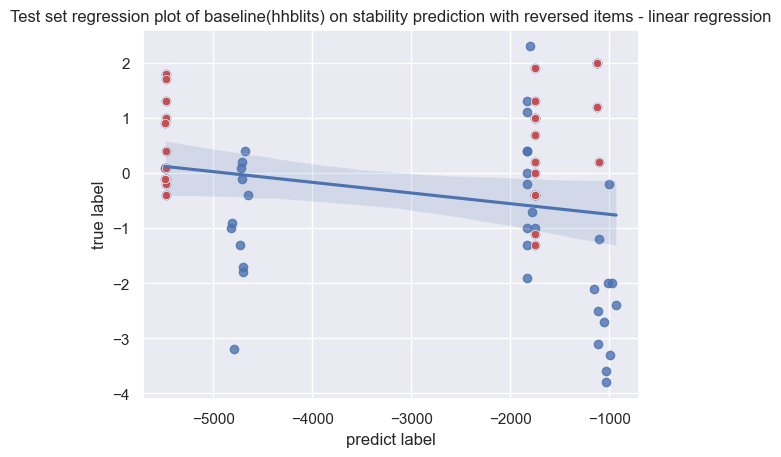

test training rmse= 3354.709504648247
test training r-square= -5032930.993417396
test training pearson-cc= -0.23232345541910837
pearson-cc p-value= 0.06921127472018429


In [16]:
from sklearn.linear_model import LinearRegression

maxlen = 512
hhm_feature = []
hhmtool = HHblits2array.HHblits2array()
hhm_path = '../../datasets/middlefile/fasta/stab_hhm/'
for i in range(train_df.shape[0]):
    hhm_before = hhmtool.convert(hhm_path + train_df['pdb_id'][i] + '_' + train_df['pdb_chain'][i] + '.hhm', maxlen).flatten().tolist()
    hhm_after = hhmtool.convert(hhm_path + train_df['pdb_id'][i] + '_' + train_df['pdb_chain'][i] + '_' + train_df['shifted_mutation'][i] + '.hhm', maxlen).flatten().tolist()
    hhm_feature.append(hhm_before + hhm_after)

X_train = np.array(hhm_feature)
Y_train = train_df['ddg'].values
print(X_train.shape)
print(Y_train.shape)

clf = LinearRegression()
clf.fit(X_train, Y_train)

# try test set performance with reversed items

maxlen = 512
hhm_feature = []
hhmtool = HHblits2array.HHblits2array()
hhm_path = '../../datasets/middlefile/fasta/stab_hhm/'
for i in range(test_df.shape[0]):
    hhm_before = hhmtool.convert(hhm_path + test_df['pdb_id'][i] + '_' + test_df['pdb_chain'][i] + '.hhm', maxlen).flatten().tolist()
    hhm_after = hhmtool.convert(hhm_path + test_df['pdb_id'][i] + '_' + test_df['pdb_chain'][i] + '_' + test_df['shifted_mutation'][i] + '.hhm', maxlen).flatten().tolist()
    hhm_feature.append(hhm_before + hhm_after)

origin_X_test = np.array(hhm_feature)
origin_Y_test = test_df['ddg'].values
print(origin_X_test.shape)
print(origin_Y_test.shape)

maxlen = 512
hhm_feature = []
hhmtool = HHblits2array.HHblits2array()
hhm_path = '../../datasets/middlefile/fasta/stab_hhm/'
for i in range(reversed_test_df.shape[0]):
    hhm_before = hhmtool.convert(hhm_path + reversed_test_df['pdb_id'][i] + '_' + reversed_test_df['pdb_chain'][i] + '_' + reversed_test_df['shifted_mutation'][i] + '.hhm', maxlen).flatten().tolist()
    hhm_after = hhmtool.convert(hhm_path + reversed_test_df['pdb_id'][i] + '_' + reversed_test_df['pdb_chain'][i] + '.hhm', maxlen).flatten().tolist()
    hhm_feature.append(hhm_before + hhm_after)

reversed_X_test = np.array(hhm_feature)
reversed_Y_test = reversed_test_df['ddg'].values
print(reversed_X_test.shape)
print(reversed_Y_test.shape)

X_test = np.concatenate((origin_X_test,reversed_X_test),axis=0)
Y_test = np.concatenate((origin_Y_test,reversed_Y_test),axis=0)
print(X_test.shape)
print(Y_test.shape)

Y_pred = clf.predict(X_test)

plt.title('Test set regression plot of baseline(hhblits) on stability prediction with reversed items - linear regression')
plt.ylabel("true label")
plt.xlabel("predict label")
sns.regplot(x=Y_pred,y=Y_test,color='b')
sns.scatterplot(x=Y_pred[origin_X_test.shape[0]:],y=Y_test[origin_Y_test.shape[0]:],color='r')
plt.savefig('images/stab-hhblits/hhblits-lr-test-all.png',dpi=300, bbox_inches = 'tight')
plt.show()

print('test training rmse=', np.sqrt(mean_squared_error(Y_test, Y_pred)))
print('test training r-square=', r2_score(Y_test, Y_pred))
print('test training pearson-cc=',pearsonr(Y_test, Y_pred)[0])
print('pearson-cc p-value=',pearsonr(Y_test, Y_pred)[1])

In [17]:
# try test set performance: prepare full training set
maxlen = 512
hhm_feature = []
hhmtool = HHblits2array.HHblits2array()
hhm_path = '../../datasets/middlefile/fasta/stab_hhm/'
for i in range(train_df.shape[0]):
    hhm_before = hhmtool.convert(hhm_path + train_df['pdb_id'][i] + '_' + train_df['pdb_chain'][i] + '.hhm', maxlen).flatten().tolist()
    hhm_after = hhmtool.convert(hhm_path + train_df['pdb_id'][i] + '_' + train_df['pdb_chain'][i] + '_' + train_df['shifted_mutation'][i] + '.hhm', maxlen).flatten().tolist()
    hhm_feature.append(hhm_before + hhm_after)

X_train = np.array(hhm_feature)
Y_train = train_df['ddg'].values
print(X_train.shape)
print(Y_train.shape)

other_params = {'learning_rate': 0.01, 'n_estimators': 10000, 'max_depth': 5, 'min_child_weight': 1, 'seed': 0,
                    'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 1}


#cv_params = {'n_estimators': [400, 500, 600, 700, 800]} # 500
#cv_params = {'n_estimators': [400, 450, 500, 550]} # 450
#cv_params = {'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.3]} # 0.01
#cv_params = {'max_depth': [5, 10, 20, 50]}
'''
clf = XGBRegressor(**other_params)
from sklearn.model_selection import GridSearchCV
optimized_GBM = GridSearchCV(estimator=clf, param_grid=cv_params, scoring='r2', cv=3, verbose=1, n_jobs=-1)
optimized_GBM.fit(X_train, Y_train)
print(optimized_GBM.best_params_)
'''

clf = XGBRegressor(**other_params)
clf.fit(X_train, Y_train)

# save model
clf.save_model('model/stab_xgb_hhblits_10000.json')
# load model
clf = XGBRegressor(n_jobs=-1)
clf.load_model('model/stab_xgb_hhblits_10000.json')

(187, 30720)
(187,)


(36, 30720)
(36,)
(26, 30720)
(26,)
(62, 30720)
(62,)


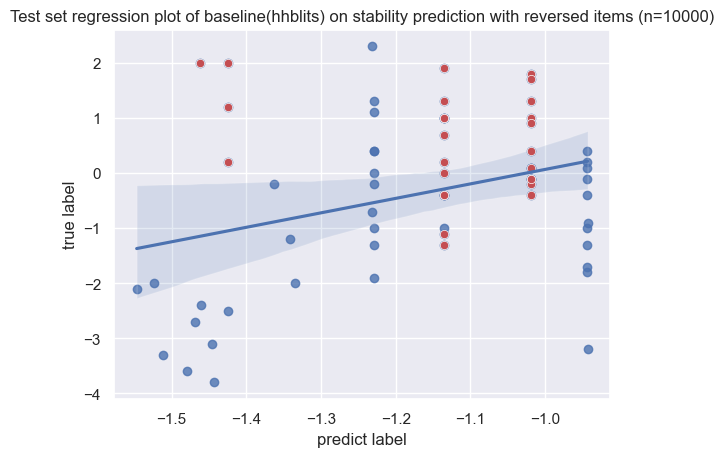

test training rmse= 1.6432957249725304
test training r-square= -0.20765441856417666
test training pearson-cc= 0.32551231517482926
pearson-cc p-value= 0.009832874869834252


In [18]:
# try test set performance with reversed items

maxlen = 512
hhm_feature = []
hhmtool = HHblits2array.HHblits2array()
hhm_path = '../../datasets/middlefile/fasta/stab_hhm/'
for i in range(test_df.shape[0]):
    hhm_before = hhmtool.convert(hhm_path + test_df['pdb_id'][i] + '_' + test_df['pdb_chain'][i] + '.hhm', maxlen).flatten().tolist()
    hhm_after = hhmtool.convert(hhm_path + test_df['pdb_id'][i] + '_' + test_df['pdb_chain'][i] + '_' + test_df['shifted_mutation'][i] + '.hhm', maxlen).flatten().tolist()
    hhm_feature.append(hhm_before + hhm_after)

origin_X_test = np.array(hhm_feature)
origin_Y_test = test_df['ddg'].values
print(origin_X_test.shape)
print(origin_Y_test.shape)

maxlen = 512
hhm_feature = []
hhmtool = HHblits2array.HHblits2array()
hhm_path = '../../datasets/middlefile/fasta/stab_hhm/'
for i in range(reversed_test_df.shape[0]):
    hhm_before = hhmtool.convert(hhm_path + reversed_test_df['pdb_id'][i] + '_' + reversed_test_df['pdb_chain'][i] + '_' + reversed_test_df['shifted_mutation'][i] + '.hhm', maxlen).flatten().tolist()
    hhm_after = hhmtool.convert(hhm_path + reversed_test_df['pdb_id'][i] + '_' + reversed_test_df['pdb_chain'][i] + '.hhm', maxlen).flatten().tolist()
    hhm_feature.append(hhm_before + hhm_after)

reversed_X_test = np.array(hhm_feature)
reversed_Y_test = reversed_test_df['ddg'].values
print(reversed_X_test.shape)
print(reversed_Y_test.shape)

X_test = np.concatenate((origin_X_test,reversed_X_test),axis=0)
Y_test = np.concatenate((origin_Y_test,reversed_Y_test),axis=0)
print(X_test.shape)
print(Y_test.shape)

Y_pred = clf.predict(X_test)

plt.title('Test set regression plot of baseline(hhblits) on stability prediction with reversed items (n=10000)')
plt.ylabel("true label")
plt.xlabel("predict label")
sns.regplot(x=Y_pred,y=Y_test,color='b')
sns.scatterplot(x=Y_pred[origin_X_test.shape[0]:],y=Y_test[origin_Y_test.shape[0]:],color='r')
plt.savefig('images/stab-hhblits/hhblits-xgb-test-all-10000.png',dpi=300, bbox_inches = 'tight')
plt.show()

print('test training rmse=', np.sqrt(mean_squared_error(Y_test, Y_pred)))
print('test training r-square=', r2_score(Y_test, Y_pred))
print('test training pearson-cc=',pearsonr(Y_test, Y_pred)[0])
print('pearson-cc p-value=',pearsonr(Y_test, Y_pred)[1])